In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
##read in globalisation data
OPIX = pd.read_pickle('../../data/OPIX.pkl')
OPIX.rename(columns = {'Openness Index PWT':'OPIX'}, inplace = True)

## Directed Weighted Graphs

In [ ]:
## read in weighted, directed trade data
data = pd.read_pickle('../../data/baci_weighted.pkl')

In [3]:
## create directed graphs from dataframes

G96 = nx.from_pandas_edgelist(data[(data['t']==1996)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G97 = nx.from_pandas_edgelist(data[(data['t']==1997)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G98 = nx.from_pandas_edgelist(data[(data['t']==1998)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G99 = nx.from_pandas_edgelist(data[(data['t']==1999)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G00 = nx.from_pandas_edgelist(data[(data['t']==2000)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G01 = nx.from_pandas_edgelist(data[(data['t']==2001)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G02 = nx.from_pandas_edgelist(data[(data['t']==2002)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G03 = nx.from_pandas_edgelist(data[(data['t']==2003)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G04 = nx.from_pandas_edgelist(data[(data['t']==2004)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G05 = nx.from_pandas_edgelist(data[(data['t']==2005)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G06 = nx.from_pandas_edgelist(data[(data['t']==2006)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G07 = nx.from_pandas_edgelist(data[(data['t']==2007)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())

##TODO: subset graphs to kgN


In [4]:
## read in graphs

#year_list = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007']
#graph_list = [G96,G97,G98,G99,G00,G01,G02,G03,G04,G05,G06,G07]

#for G,year in zip(graph_list,year_list):
#        G = nx.read_gpickle('../../data/graphs/G'+ year[-2:] +'.gpickle')

In [74]:
print(G07.get_edge_data(156, 842))

{'v_minmax_scale': 1.0, 'v_share': 0.19905747550955094}


In [75]:
print(G07.get_edge_data(842, 156))

{'v_minmax_scale': 0.28128335712934743, 'v_share': 0.055236508539765174}


## Undirected Weighted Average Graphs

In [3]:
## read in weighted average, undirected trade data
data_avg = pd.read_pickle('../../data/baci_weighted_average.pkl')

In [89]:
## create undirected weighted average graphs from dataframes

N96 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1996)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N97 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1997)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N98 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1998)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N99 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1999)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N00 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2000)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N01 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2001)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N02 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2002)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N03 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2003)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N04 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2004)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N05 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2005)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N06 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2006)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N07 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2007)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N08 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2008)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N09 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2009)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N10 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2010)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N11 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2011)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N12 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2012)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N13 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2013)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N14 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2014)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N15 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2015)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N16 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2016)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N17 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2017)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
#N18 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2018)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
#N19 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2019)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())


In [51]:
print(N11.get_edge_data(156, 842))

{'v_minmax_avg': 0.7037618287264844}


In [90]:
graph_list = [N96,N97,N98,N99,N00,N01,N02,N03,N04,N05,N06,N07,N08,N09,N10,N11,N12,N13,N14,N15,N16,N17]


##TODO: subset graphs to kgN
node_set_list = [set(N96),set(N97),set(N98),set(N99),set(N00),set(N01),set(N02),set(N03),set(N04),set(N05),set(N06),set(N07),set(N08),set(N09),set(N10),set(N11),set(N12),set(N13),set(N14),set(N15),set(N16),set(N17)]

i = set.intersection(*node_set_list)
u = set.union(*node_set_list)

#difference, i.e. nodes not in all networks
c = u.difference(i)
print(c)

# remove nodes from graphs
for N in graph_list:
    N.remove_nodes_from(c)

## check which countries were affected
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')
country_codes.head()

dropped_states = []
for i in c:
    dropped_states.append(country_codes[country_codes['country_code']==i]['country_name_abbreviation'])

# print names
print(dropped_states)

{516, 652, 16, 530, 275, 531, 534, 535, 674, 426, 175, 688, 56, 697, 442, 58, 316, 710, 711, 72, 849, 728, 729, 736, 748, 499, 891}
[138    Namibia
Name: country_name_abbreviation, dtype: object, 175    Saint Barthélemy
Name: country_name_abbreviation, dtype: object, 3    American Samoa
Name: country_name_abbreviation, dtype: object, 142    Neth. Antilles
Name: country_name_abbreviation, dtype: object, 77    State of Palestine
Name: country_name_abbreviation, dtype: object, 143    Curaçao
Name: country_name_abbreviation, dtype: object, 145    Saint Maarten
Name: country_name_abbreviation, dtype: object, 146    Bonaire
Name: country_name_abbreviation, dtype: object, 182    San Marino
Name: country_name_abbreviation, dtype: object, 114    Lesotho
Name: country_name_abbreviation, dtype: object, 47    Mayotte
Name: country_name_abbreviation, dtype: object, 186    Serbia
Name: country_name_abbreviation, dtype: object, 16    Belgium
Name: country_name_abbreviation, dtype: object, 189    Euro

# Analysis

## Globalization

In [38]:
OPIX.dropna()
year_list_int = [1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
OPIX = OPIX[OPIX['Year'].isin(year_list_int)]
OPIX

,Year,OPIX
130,1996,41.847786
131,1997,43.588886
132,1998,43.267681
133,1999,43.487377
134,2000,47.164257
135,2001,46.009953
136,2002,46.429943
137,2003,48.279873
138,2004,51.768803
139,2005,54.316380


In [44]:
## Measure 1
#total traded quantity Q p.a.
total_trade = baci.groupby(by=['t']).sum().reset_index()[['t','q']]

In [45]:
total_trade

,t,q
0,1996,9.496764e+09
1,2017,1.370223e+10
2,2018,1.411308e+10
3,2019,1.423137e+10


In [67]:
## Summary statistics

In [39]:
year_list = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

sumdf = pd.DataFrame()
sumdf['Year'] = year_list_int
sumdf = sumdf.merge(OPIX, left_on=['Year'] , right_on=['Year'], how='left')

In [68]:
dens = []
avg_cl = []



deg_ass = []
deg_ass2 = []

number_of_edges = []
res_dis = []
prank_usa = []
prank_china = []


for N in graph_list:
    dens.append(nx.density(N))
    #avg_cl.append(nx.average_clustering(N, weight='v_minmax_avg', count_zeros=False))
    #avg_cl.append(nx.average_clustering(N, count_zeros=False))
    #deg_ass.append(nx.degree_assortativity_coefficient(N, weight='v_minmax_avg'))
    #deg_ass2.append(nx.degree_assortativity_coefficient(N))

    ## number of edges
    
    #res_dis.append(nx.resistance_distance(N, 156, 842, weight='v_minmax_avg')) # distance China US

    #prank_usa.append(nx.pagerank_numpy(N, alpha=0.85, weight='v_minmax_avg')[842])
    #prank_china.append(nx.pagerank_numpy(N, alpha=0.85, weight='v_minmax_avg')[156])


sumdf['Density'] = dens
#sumdf['Average Clustering Coefficient'] = avg_cl
#sumdf['Degree Assortativity'] = deg_ass 
#sumdf['Degree Assortativity unweighted'] = deg_ass2

#sumdf['Resistance Distance China-USA'] = res_dis
#sumdf['Page Rank USA'] = prank_usa
#sumdf['Page Rank China'] = prank_china



In [64]:
print(avg_cl)

[0.8281079450879559, 0.8283961399617654, 0.8325683920827235, 0.8339839976742034, 0.8429862996394992, 0.8471015569550916, 0.8484892139087526, 0.8515174739905348, 0.8519184140529439, 0.8565395300036146, 0.8588369009979869, 0.8618301491068233, 0.8628207357796175, 0.8624075441715184, 0.8680678809510834, 0.8677484770926903, 0.8703947575571199, 0.8709131565849948, 0.8708974416865065, 0.8734780120967383, 0.8716281229047218, 0.8508879794443321]


In [69]:
sumdf

,Year,OPIX,Average Clustering Coefficient,Density
0,1996,41.847786,0.828108,0.523751
1,1997,43.588886,0.828396,0.556382
2,1998,43.267681,0.832568,0.570542
3,1999,43.487377,0.833984,0.581814
4,2000,47.164257,0.842986,0.631021
5,2001,46.009953,0.847102,0.646081
6,2002,46.429943,0.848489,0.655837
7,2003,48.279873,0.851517,0.670566
8,2004,51.768803,0.851918,0.682264
9,2005,54.316380,0.856540,0.687805


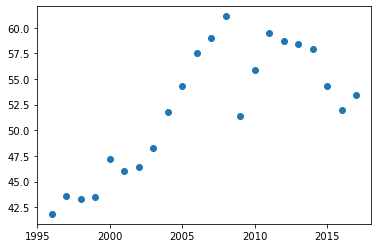

In [43]:
plt.scatter(sumdf['Year'],sumdf['OPIX'])

#plt.scatter(sumdf['OPIX'],sumdf['Page Rank China'])

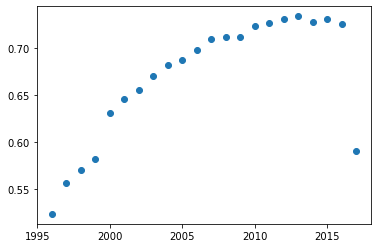

In [70]:
plt.scatter(sumdf['Year'],sumdf['Density'])


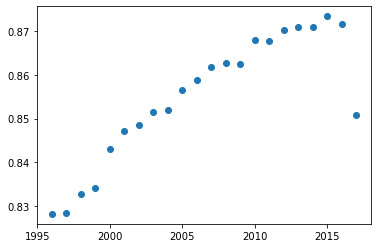

In [66]:
plt.scatter(sumdf['Year'],sumdf['Average Clustering Coefficient'])


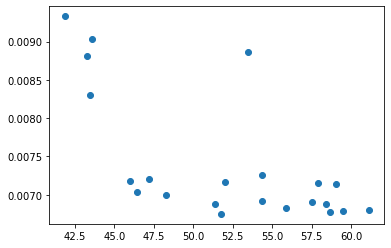

In [44]:
plt.scatter(sumdf['OPIX'],sumdf['Average Clustering Coefficient'])


In [45]:
plt.scatter(sumdf['OPIX'],sumdf['Page Rank China'])
plt.scatter(sumdf['OPIX'],sumdf['Page Rank USA'])

KeyError: 'Page Rank China'

## Plotting

In [53]:
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

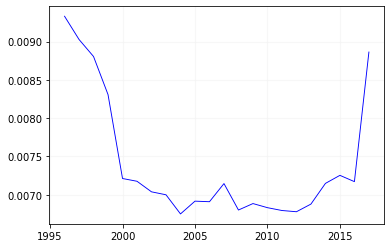

In [62]:
fig = plt.figure()
ax = plt.axes()


ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

## plot ROC curves
#ax.plot(sumdf['Year'], sumdf['OPIX'], label='Openness Index', color='b', lw=0.9)
ax.plot(sumdf['Year'], sumdf['Average Clustering Coefficient'], label='Openness Index', color='b', lw=0.9)

#ax.fill_between(FPR, TPR+0.5*TPR_err, TPR-0.5*TPR_err, alpha=0.3, color=color) # plot error shading


# Minimal Spanning Trees

In [29]:
T = nx.minimum_spanning_tree(G07.to_undirected(), weight='v_minmax_scale', algorithm='kruskal', ignore_nan=True)

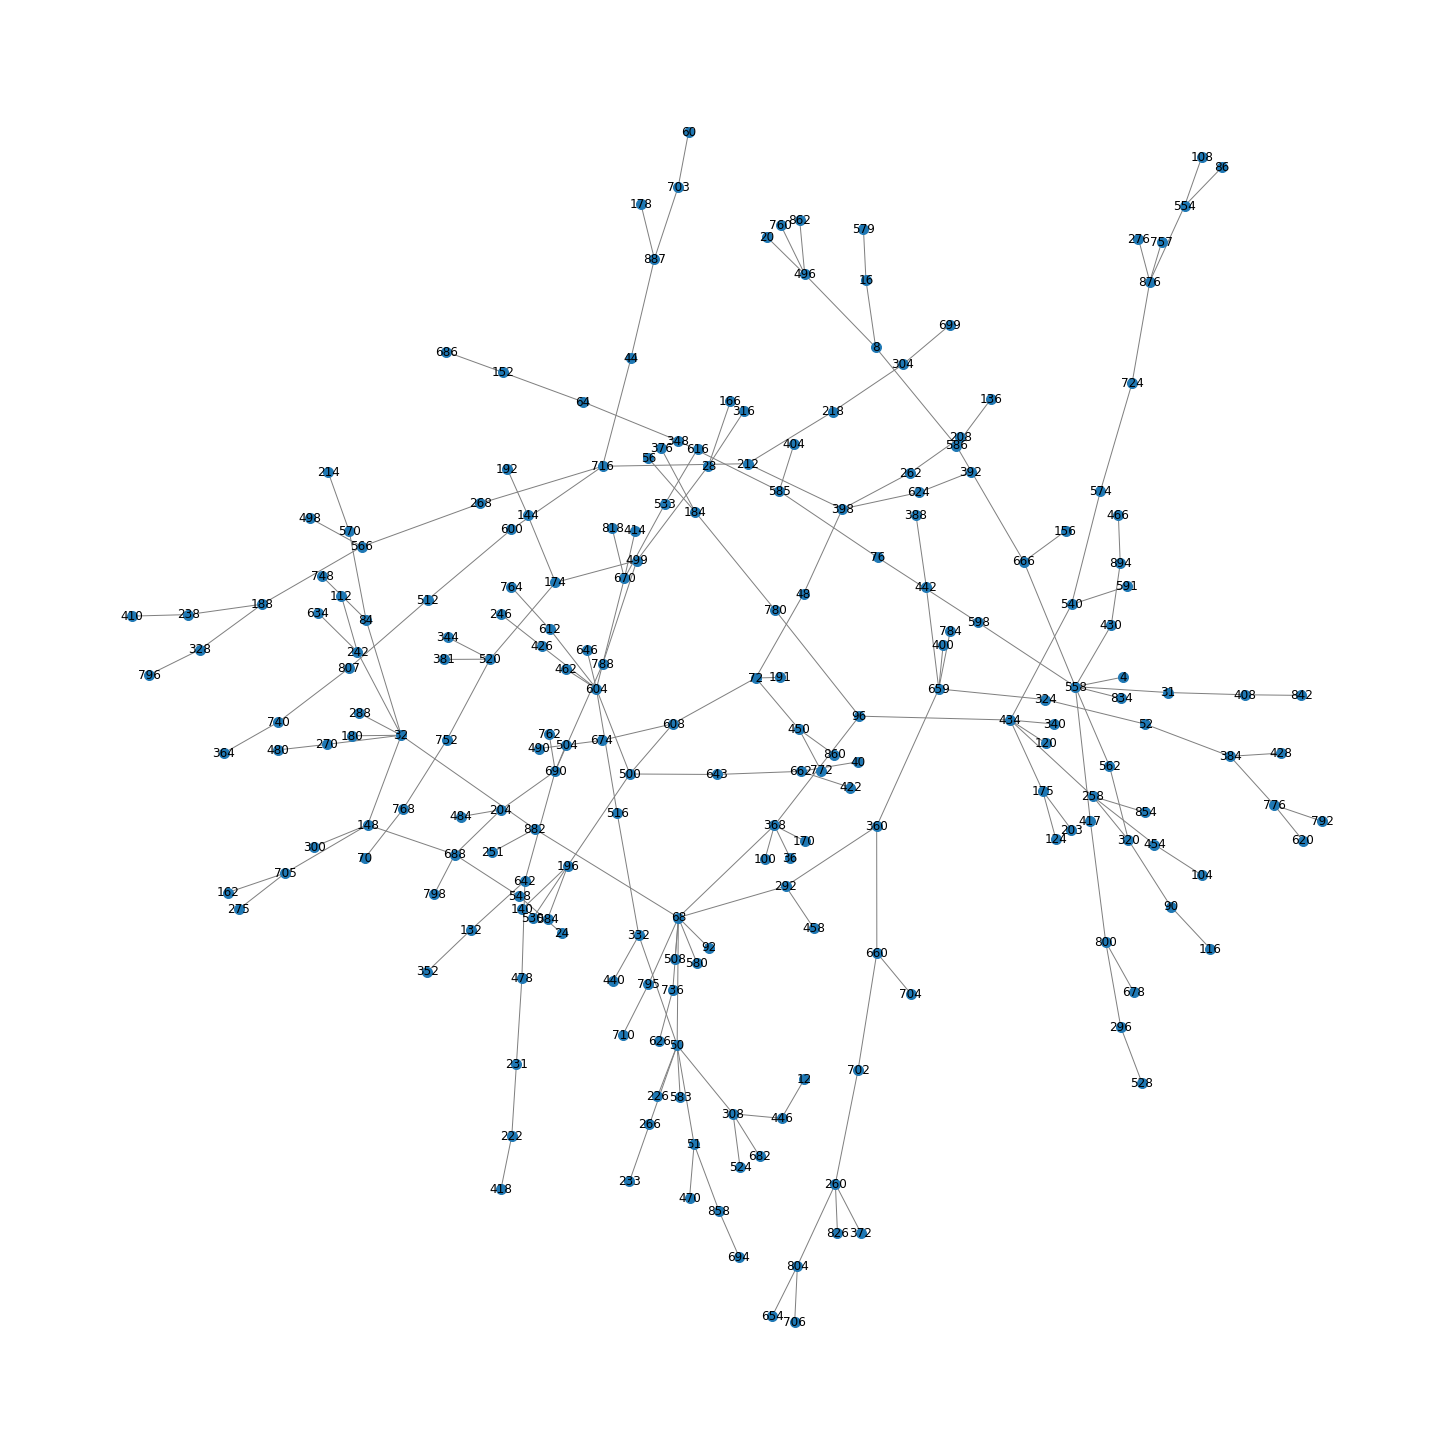

In [30]:
plt.figure(1,figsize=(20,20)) 
nx.draw(T, with_labels=True, node_size=100, edge_color='grey')

## Multipolarity

In [33]:
nx.resistance_distance(G96, 156, 842, weight='v_normalised')

5.482471573333552e-05

In [34]:
nx.resistance_distance(G18, 156, 842, weight='v_normalised')

3.358685606023053e-05

In [11]:
nx.barycenter(G17, weight='v_normalised')

[724]

In [12]:
nx.degree_assortativity_coefficient(G17)

-0.4602764343470734

In [108]:
nx.degree_assortativity_coefficient(G18)

-0.4230616191631844

In [17]:
#nx.algorithms.community.kernighan_lin_bisection(G17)

In [87]:
print(nx.average_clustering(G96))
print(nx.average_clustering(G00))
print(nx.average_clustering(G17))

0.824957820586738
0.837290112938506
0.8499617085334933


In [111]:
print(nx.clustering(G96, 156))
print(nx.clustering(G17, 156))

0.5936558287073751
0.6285425101214575


In [112]:
print(nx.clustering(G96, 842))
print(nx.clustering(G17, 842))

0.5408751934712256
0.5956181140295757


# Community Detection

In [93]:
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')

In [94]:
country_codes

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND
...,...,...,...,...,...
233,876,Wallis and Futuna Isds,Wallis and Futuna Islands,WF,WLF
234,882,Samoa,Samoa,WS,WSM
235,887,Yemen,Yemen,YE,YEM
236,891,Serbia and Montenegro,Serbia and Montenegro,CS,SCG


In [119]:
orders = nx.algorithms.community.kernighan_lin_bisection(G17, partition=None, max_iter=10, weight='weight', seed=None)

In [120]:
country_labels = dict(zip(country_codes.country_code, country_codes.iso_3digit_alpha))
#country_labels[16]

order_0 = []
for i in list(orders[0]):
    order_0.append(country_labels[i])
    
order_0 = pd.DataFrame(order_0, columns=['iso3_import'])

order_0['value'] = 1
#order_0

In [121]:
import folium
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
plotdf = world.merge(order_0, how="left", left_on=['iso_a3'], right_on=['iso3_import'])
plotdf.dropna(inplace=True)

display(plotdf)

# Create a map
my_map = folium.Map()

# Add the data
folium.Choropleth(
    geo_data=plotdf,
    name='bounded orders',
    data=plotdf,
    columns=['iso3_import', 'value'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='test'
).add_to(my_map)
my_map.save('meat.html')

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso3_import,value
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,1.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,1.0
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",UZB,1.0
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",PNG,1.0
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",IDN,1.0
...,...,...,...,...,...,...,...,...
164,6653210,Africa,Libya,LBY,90890.0,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",LBY,1.0
166,865267,Africa,Djibouti,DJI,3345.0,"POLYGON ((42.35156 12.54223, 42.77964 12.45542...",DJI,1.0
169,11901484,Africa,Rwanda,RWA,21970.0,"POLYGON ((30.41910 -1.13466, 30.81613 -1.69891...",RWA,1.0
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",SRB,1.0


In [122]:
my_map

In [116]:

#import networkx as nx
#import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pathlib

import infomap

"""
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.
"""


def find_communities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    im = infomap.Infomap("--two-level")

    print("Building Infomap network from a NetworkX graph...")

    im.add_networkx_graph(G)

    print("Find communities with Infomap...")
    im.run()

    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')


def draw_network(G):
    # position map
    pos = nx.spring_layout(G)
    # community index
    communities = [c - 1 for c in nx.get_node_attributes(G, 'community').values()]
    num_communities = max(communities) + 1

    # color map from http://colorbrewer2.org/
    cmap_light = colors.ListedColormap(
        ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', num_communities)
    cmap_dark = colors.ListedColormap(
        ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', num_communities)

    # edges
    nx.draw_networkx_edges(G, pos)

    # nodes
    node_collection = nx.draw_networkx_nodes(
        G, pos=pos, node_color=communities, cmap=cmap_light)

    # set node border color to the darker shade
    dark_colors = [cmap_dark(v) for v in communities]
    node_collection.set_edgecolor(dark_colors)

    # Print node labels separately instead
    for n in G.nodes:
        plt.annotate(n,
                     xy=pos[n],
                     textcoords='offset points',
                     horizontalalignment='center',
                     verticalalignment='center',
                     xytext=[0, 2],
                     color=cmap_dark(communities[n]))

    plt.axis('off')
    pathlib.Path("output").mkdir(exist_ok=True)
    print("Writing network figure to output/karate.png")
    plt.savefig("output/karate.png")
    # plt.show()


G = nx.karate_club_graph()

find_communities(G)
draw_network(G)

ImportError: dlopen(/opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so, 0x0002): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [114]:
from cdlib import algorithms

ImportError: dlopen(/opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so, 0x0002): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [115]:
import infomap

ImportError: dlopen(/opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so, 0x0002): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)